In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Краевая задача для ОДУ 2-го порядка
$u'' + {p(x)}{\cdot}u' + {q(x)}{\cdot}u = f(x), 0 < x < l$  
${\alpha}_1u(0) + {\beta}_1u'(0) = {\gamma}_1$  
${\alpha}_2u(l) + {\beta}_2u'(l) = {\gamma}_2$

### Текущая задача
$u'' + \frac{1}{1+x}{\cdot}u' + \frac{1}{(1+x)^2}{\cdot}u = \frac{2 + 6x + 5x^2}{1 + x^2}, 0 < x < 1$  
$2u(0) - u'(0) = -1$  
$3u(1) + u'(1) = 7.3015$

## Метод прогонки

In [2]:
class Equation:
    def __init__(self,p,q,f,interval,a1,b1,a2,b2,g1,g2):
        self.p = p
        self.q = q
        self.f = f
        self.x1, self.x2 = interval
        self.a1 = a1
        self.b1 = b1
        self.a2 = a2
        self.b2 = b2
        self.g1 = g1
        self.g2 = g2

In [40]:
class ThreeDiagonalMethod():
    def __init__(self,eq):
        self.eq = eq
        
    def get_matrix_coeffs(self, h, n, order):
        '''
        h: step of grid
        n: count of nodes - 1
        order: level of precision of solution
        '''
        eq = self.eq
        a = list(range(n))
        b = list(range(n+1))
        c = list(range(n))        
        
        if order == 1:
            b[0] = eq.a1 - eq.b1/h
            c[0] = eq.b1/h
            a[-1] = -eq.b2/h
            b[-1] = eq.a2 + eq.b2/h
        elif order == 2:
            x0 = eq.x1
            xn = eq.x2
            b[0] = (h**2)*eq.q(x0) - (eq.a1*(h**2)*eq.p(x0)) / eq.b1 + (2*eq.a1*h)/eq.b1 - 2
            c[0] = 2
            a[-1] = 2
            b[-1] = (h**2)*eq.q(xn) - (eq.a2*(h**2)*eq.p(xn)) / eq.b2 - (2*eq.a2*h)/eq.b2 - 2
        else:
            raise ValueError('order should be equal to 1 or 2')

        x_k = eq.x1 + h
        for k in range(1,n):
            a[k-1] = (1/h**2 - eq.p(x_k)/(2*h)) ##-h 
            b[k] = (-2/h**2 + eq.q(x_k))
            c[k] = (1/h**2 + eq.p(x_k)/(2*h))
            x_k += h
            
        return (a,b,c)

    def get_rhs_coeffs(self, h, n, order):
        eq = self.eq
        f = list(range(n+1))
        
        if order == 1:
            f[0] = eq.g1
            f[-1] = eq.g2
        elif order == 2:
            f[0] = -(eq.g1*(h**2)*eq.p(eq.x1)) / eq.b1 + eq.f(eq.x1) * (h**2) + (2*eq.g1*h)/eq.b1
            f[-1] = -(eq.g2*(h**2)*eq.p(eq.x2)) / eq.b2 + eq.f(eq.x2) * (h**2) - (2*eq.g2*h)/eq.b2
        else:
            raise ValueError('order should be equal to 1 or 2')
        
        x_k = eq.x1 + h
        for i in range(1,n):
            f[i] = eq.f(x_k)
            x_k += h        
        
        return f
        
    def solve(self, h, n, order):
        a, b, c = self.get_matrix_coeffs(h, n , order)
        f = self.get_rhs_coeffs(h, n, order)
        
        # get values of A[i] B[i]
        A = list(range(n+1))
        B = list(range(n+1))
        A[0] = - c[0]/b[0]
        B[0] =  f[0]/b[0]
        
        for i in range(1,n):
            A[i] = - c[i] / (b[i] + a[i - 1] * A[i-1]) # a[i-1] = a_i
            B[i] = (f[i] - a[i - 1] * B[i-1]) / (b[i] + a[i - 1] * A[i-1])
        A[n] = 0
        B[n] = (f[n] - a[n - 1] * B[n-1]) / (b[n] + a[n - 1] * A[n-1])
        
        
        # get values of u[i]
        u = list(range(n+1))
        u[n] = B[n]
        for i in range(n-1,-1,-1):
            u[i] = B[i] + A[i] * u[i+1]
        return u
        

In [41]:
def true_u(x):
    return x**2 + np.sin(np.log(1+x))

def true_u_deriv(x):
    return 2*x + np.cos(np.log(1+x))/(1+x)

def p(x):
    return 1/(1+x)

def q(x):
    return 1/(1+x)**2

def f(x):
    return (2 + 6*x + 5*x**2)/(1+x)**2

eq = Equation(p,q,f,(0,1),2,-1,3,1,-1,3*true_u(1) + true_u_deriv(1))
tgm = ThreeDiagonalMethod(eq)

In [42]:
def compute_error(tgm,h,n,order):
    return max(abs(np.array(tgm.solve(h,n,order)) - true_u(np.linspace(0,1,n+1))))

In [46]:
def plot_tgm_error(tgm):
    nn = np.array(range(10,2000))
    hh = 1/nn
    errors1 = []
    errors2 = []
    for n, h in zip(nn,hh):
        errors1.append(compute_error(tgm,h,n,1))
        errors2.append(compute_error(tgm,h,n,2))
    
    plt.figure(figsize=(10,6))
    plt.plot(np.log(hh),np.log(errors1),'r-',label='First order')
    plt.plot(np.log(hh),np.log(errors2),'b-',label='Second_order')
    plt.legend()

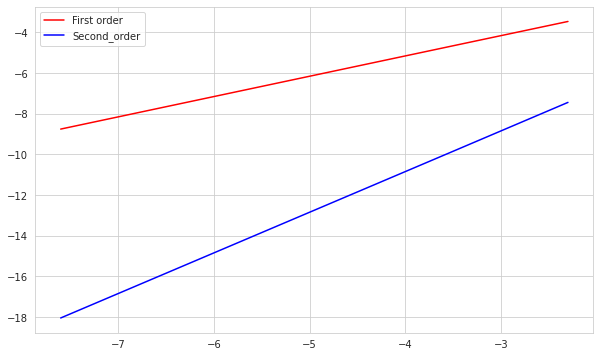

In [47]:
plot_tgm_error(tgm)

In [59]:
n = 200
abs(np.array(tgm.solve(1/n,n,2)) - true_u(np.linspace(0,1,n+1)))

array([1.45902293e-06, 1.45272537e-06, 1.44632235e-06, 1.43981773e-06,
       1.43321525e-06, 1.42651851e-06, 1.41973103e-06, 1.41285622e-06,
       1.40589737e-06, 1.39885768e-06, 1.39174026e-06, 1.38454810e-06,
       1.37728414e-06, 1.36995120e-06, 1.36255203e-06, 1.35508928e-06,
       1.34756555e-06, 1.33998333e-06, 1.33234507e-06, 1.32465310e-06,
       1.31690974e-06, 1.30911719e-06, 1.30127761e-06, 1.29339309e-06,
       1.28546567e-06, 1.27749730e-06, 1.26948990e-06, 1.26144532e-06,
       1.25336537e-06, 1.24525179e-06, 1.23710628e-06, 1.22893047e-06,
       1.22072598e-06, 1.21249434e-06, 1.20423707e-06, 1.19595562e-06,
       1.18765141e-06, 1.17932582e-06, 1.17098019e-06, 1.16261581e-06,
       1.15423393e-06, 1.14583580e-06, 1.13742258e-06, 1.12899543e-06,
       1.12055548e-06, 1.11210380e-06, 1.10364144e-06, 1.09516944e-06,
       1.08668879e-06, 1.07820044e-06, 1.06970533e-06, 1.06120438e-06,
       1.05269845e-06, 1.04418842e-06, 1.03567511e-06, 1.02715932e-06,
      

## Метод стрельбы

In [14]:
import import_ipynb
from lab5 import Diff_equation
from lab4 import dichotomy

In [9]:
def plot_solution(u,n):
    x = np.linspace(0,1,n+1)
    plt.figure(figsize=(10,6))
    plt.plot(x,u,'b--',label='shooting')
    plt.plot(x,true_u(x),'r',label='real u')
    plt.legend()

In [10]:
class ShootMethod:
    def __init__(self, eq):
        self.eq = eq
    
    def solve_for_k(self,h,n,eps=1e-6):
        eq = self.eq
        k1 = 0
        k2 = 10
        
        def g(k):
            sol = self.solve_with_ics_k(h,n,k)
            u, u_deriv = sol[-1][0], sol[-1][1]
            g2_numeric = u*eq.a2 + u_deriv*eq.b2
            return g2_numeric - eq.g2
    
        k_opt,_ = dichotomy(g,k1,k2,eps=eps)
        
        return k_opt
    
    def animate_shooting(self,h,n,eps=1e-6):
        eq = self.eq
        k1 = 0
        k2 = 10
        
        def g(k):
            sol = self.solve_with_ics_k(h,n,k)
            u, u_deriv = sol[-1][0], sol[-1][1]
            g2_numeric = u*eq.a2 + u_deriv*eq.b2
            return g2_numeric - eq.g2
        
        k_opt, num_iter = dichotomy(g,k1,k2,eps=eps)
        
        for i in range(1,num_iter+1):
            k, _ = dichotomy(g,k1,k2,eps=eps,max_iter_count=i)
            solution = shm.solve_with_ics_k(h,n,k)
            plot_solution(solution[:,0],n)
            plt.draw()

        
    def find_k2(self,h,n,k_i):
        sol_i = self.solve_with_ics_k(h,n,k_i)
        u, u_deriv = (sol_i[-1])[0],(sol_i[-1])[1] 
        g2_i = u*eq.a2 + u_deriv*eq.b2   
        
        k_i_1 = k_i
        num_iter = 0
        
        sol_i_1 = self.solve_with_ics_k(h,n,k_i_1)
        u, u_deriv = (sol_i_1[-1])[0],(sol_i_1[-1])[1] 
        g2_i_1 = u*eq.a2 + u_deriv*eq.b2           
        
        while (g2_i-eq.g2)*(g2_i_1 - eq.g2) > 0:
            k_i_1 += 1
            sol_i_1 = self.solve_with_ics_k(h,n,k_i_1)
            u, u_deriv = (sol_i_1[-1])[0],(sol_i_1[-1])[1] 
            g2_i_1 = u*eq.a2 + u_deriv*eq.b2          
            num_iter+=1

        return k_i_1
    
    def solve_with_ics_k(self, h, n, k):
        def f(x,u,u_deriv):
            return eq.f(x) - u*eq.q(x) - u_deriv*eq.p(x)
        eq = self.eq
        u1 = k 
        u0 = (eq.g1 - eq.b1*k) / eq.a1
        de = Diff_equation(f,(eq.x1,eq.x2),ics=(u0,u1),x0=eq.x1)
        return de.rk4(h,n)[:,[1,2]]

In [61]:
shm=ShootMethod(eq)
n = 1000
k_opt = shm.solve_for_k(1/n,n,eps=1e-9)
solution = shm.solve_with_ics_k(1/n,n,k_opt)

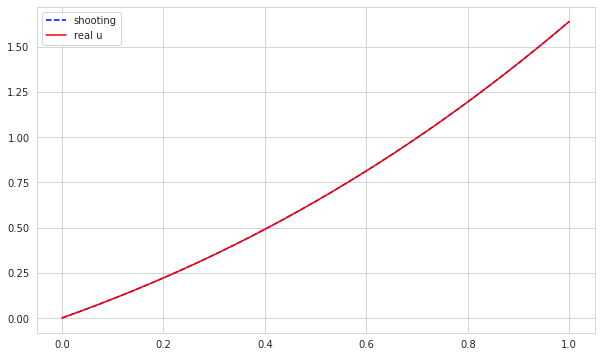

In [12]:
plot_solution(solution[:,0],n)

/tmp/ipykernel_1009022/295806400.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,6))


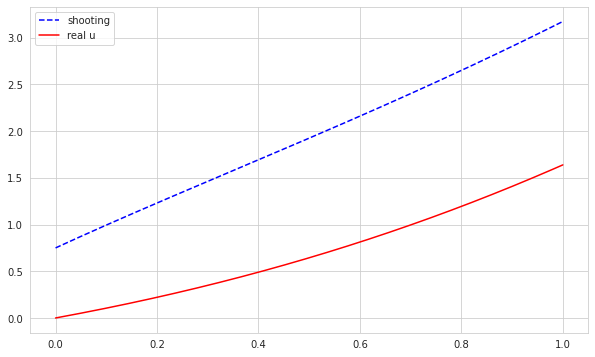

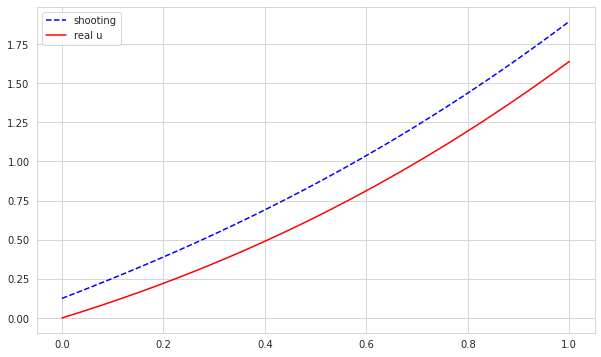

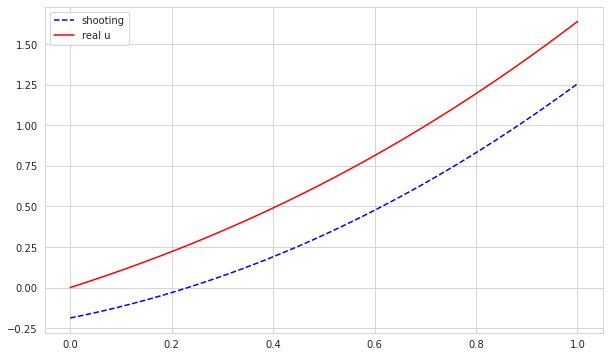

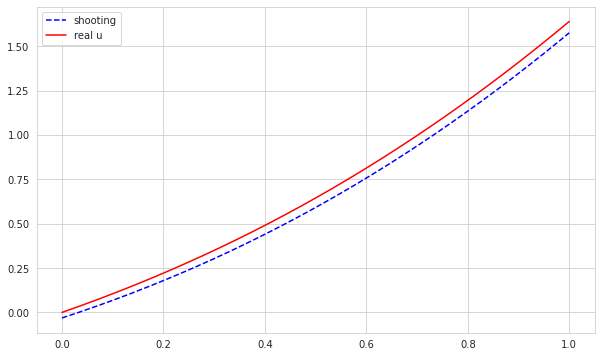

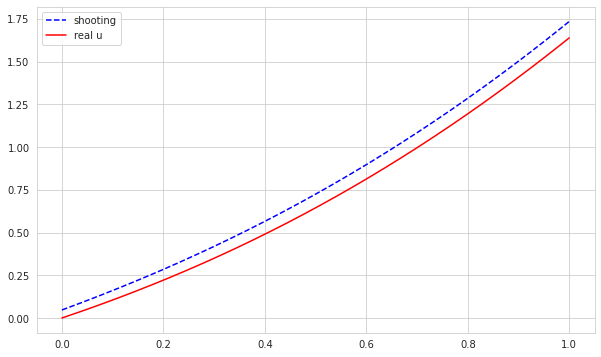

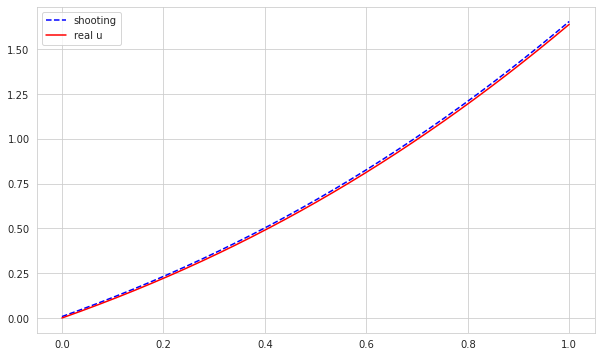

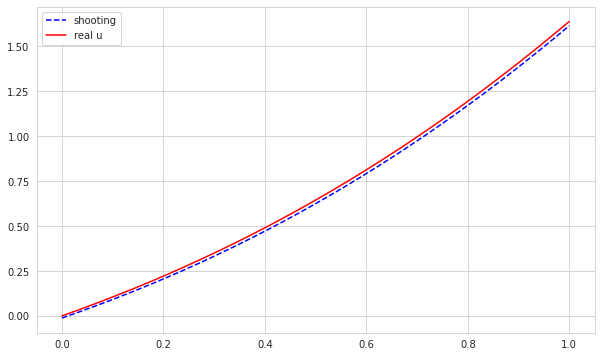

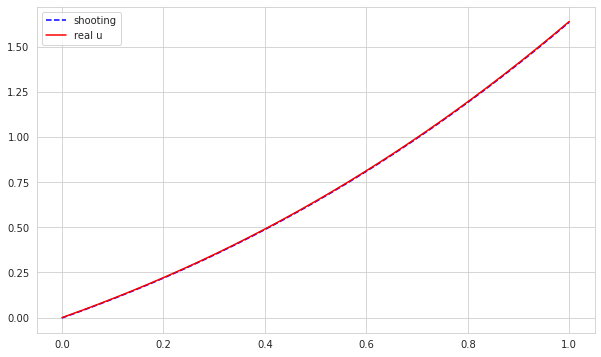

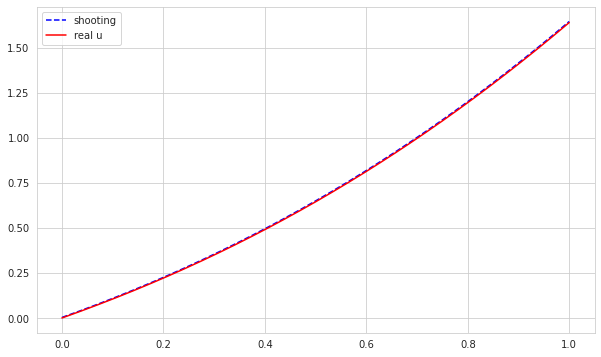

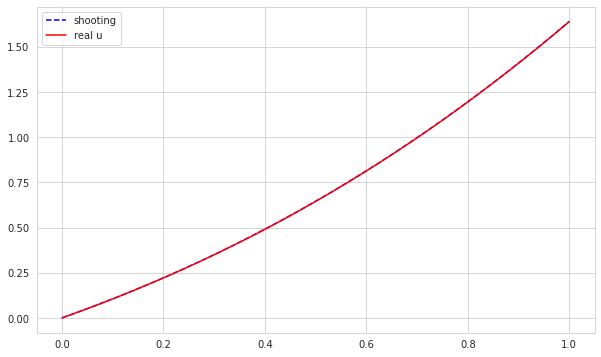

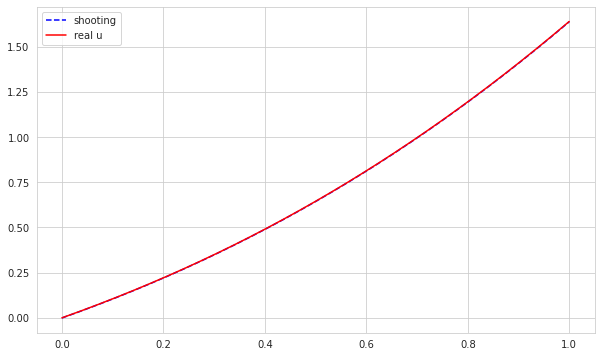

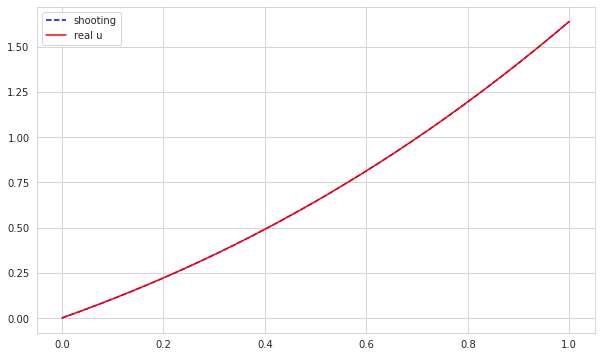

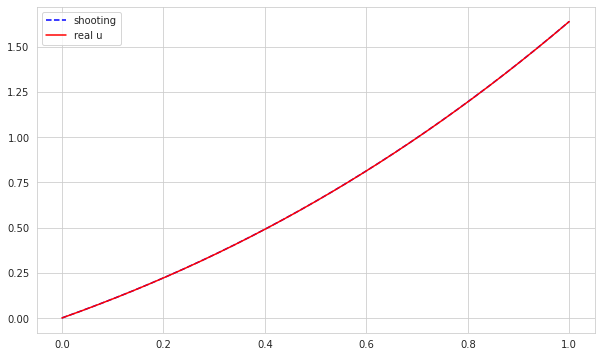

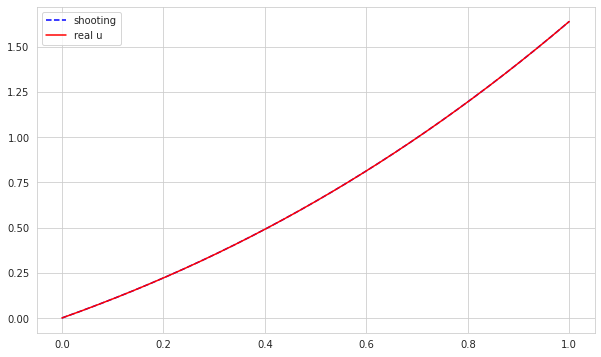

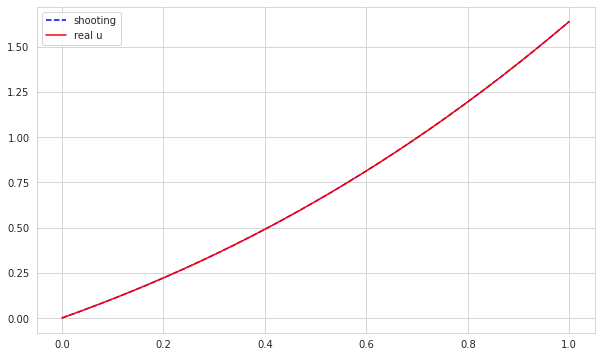

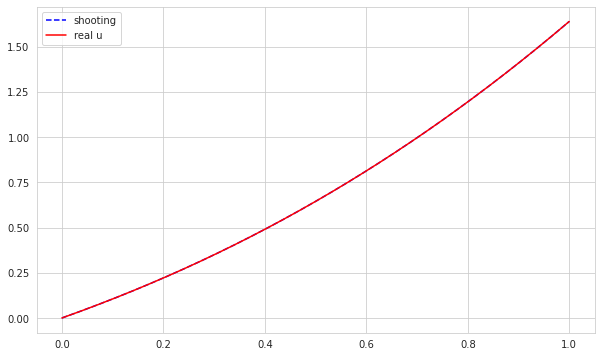

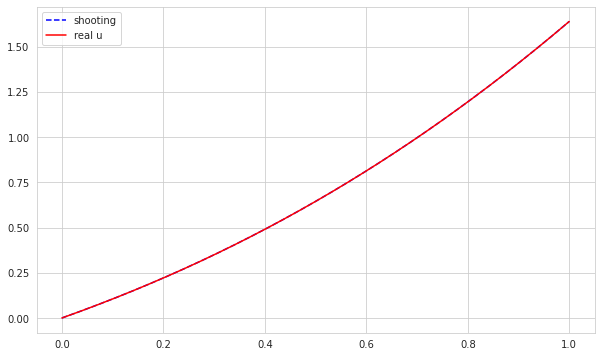

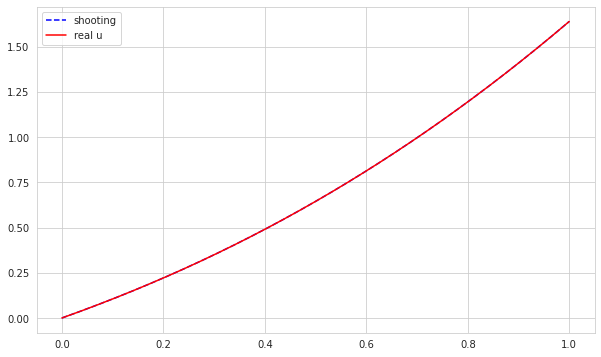

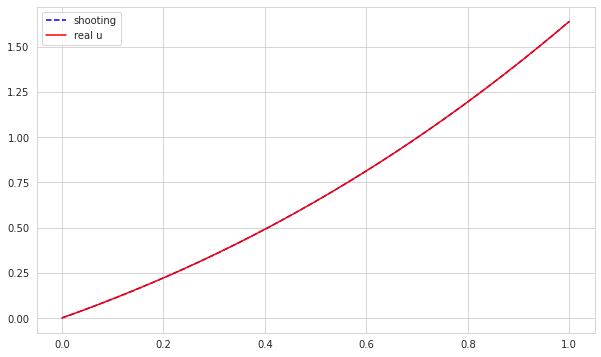

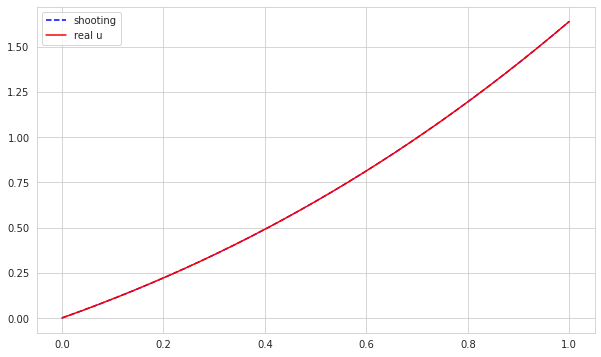

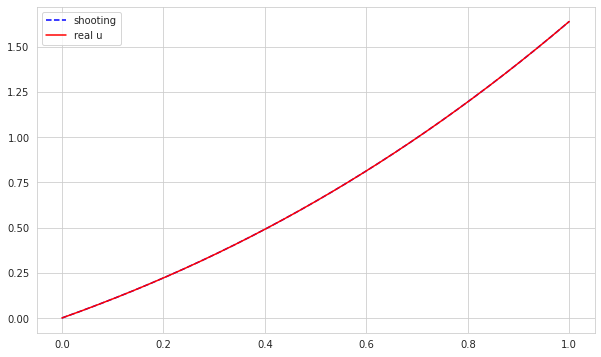

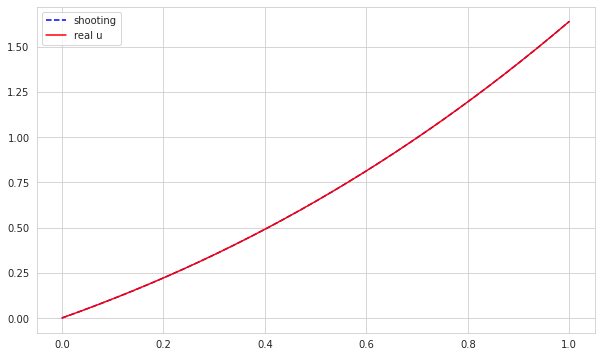

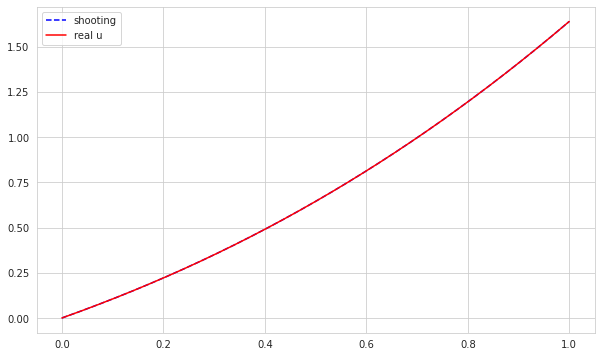

In [13]:
shm.animate_shooting(1/n,n)

In [62]:
abs(solution[:,0] - true_u(np.linspace(0,1,n+1)))

array([1.74622983e-10, 1.74972077e-10, 1.75320426e-10, ...,
       3.57319729e-10, 3.57398111e-10, 3.57476937e-10])